# Prepare data

In [1]:
from datasets import load_dataset
from PIL import Image

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

ds = load_dataset("salma-remyx/PoseText", split="train")

In [5]:
ds[1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>,
 'messages': [{'content': [{'index': 0, 'text': None, 'type': 'image'},
    {'index': None,
     'text': 'Please provide pose estimate for the left leg for the person on the left in the image.',
     'type': 'text'}],
   'role': 'user'},
  {'content': [{'index': None,
     'text': '<points x1="81.2" y1="63.1" x2="70.8" y2="73.3" x3="69.0" y3="98.2" />',
     'type': 'text'}],
   'role': 'assistant'},
  {'content': [{'index': 0, 'text': None, 'type': 'image'},
    {'index': None,
     'text': 'Please provide pose estimate for the right arm for the person on the right in the image.',
     'type': 'text'}],
   'role': 'user'},
  {'content': [{'index': None,
     'text': '<points x1="45.6" y1="35.6" x2="56.3" y2="53.6" x3="54.8" y3="37.1" />',
     'type': 'text'}],
   'role': 'assistant'}]}

In [3]:
def convert_to_sft_format(example):
    # 初始化新的資料結構
    new_examples = []
    
    # 獲取圖片
    image = example['image']
    
    # 遍歷所有對話
    messages = example['messages']
    for i in range(0, len(messages), 2):
        if i + 1 < len(messages):
            user_msg = messages[i]
            assistant_msg = messages[i + 1]
            
            # 提取問題文字
            question = next((item['text'] for item in user_msg['content'] if item['type'] == 'text'), None)
            
            # 提取回答文字
            answer = next((item['text'] for item in assistant_msg['content'] if item['type'] == 'text'), None)
            
            if question and answer:
                # 創建符合 SFT 格式的對話
                sft_example = {
                    "messages": [
                        {
                            "role": "system",
                            "content": "You are a helpful AI assistant that provides pose estimation for images."
                        },
                        {
                            "role": "user",
                            "content": [
                                {"type": "image", "image": image},
                                {"type": "text", "text": question}
                            ]
                        },
                        {
                            "role": "assistant",
                            "content": answer
                        }
                    ]
                }
                new_examples.append(sft_example)
    
    return new_examples

# 重新組織資料集
sft_dataset = []
for example in ds:
    new_examples = convert_to_sft_format(example)
    sft_dataset.extend(new_examples)

# 顯示第一個重新組織後的範例
print("SFT 格式的資料範例：")
print(sft_dataset[0])


SFT 格式的資料範例：
{'messages': [{'role': 'system', 'content': 'You are a helpful AI assistant that provides pose estimation for images.'}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x7F084822E950>}, {'type': 'text', 'text': 'I want the keypoints for the left arm for the person on the left in the image.'}]}, {'role': 'assistant', 'content': '<points x1="54.1" y1="25.7" x2="54.1" y2="33.3" x3="53.8" y3="43.5" />'}]}


In [7]:
sft_dataset[-1]

{'messages': [{'role': 'system',
   'content': 'You are a helpful AI assistant that provides pose estimation for images.'},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>},
    {'type': 'text',
     'text': 'I want the keypoints for the right arm for the person on the right in the image.'}]},
  {'role': 'assistant',
   'content': '<points x1="19.4" y1="38.6" x2="14.6" y2="50.7" x3="14.1" y3="65.0" />'}]}

# training

In [4]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

In [5]:


# Hugging Face model id
model_id = "google/gemma-3-4b-pt" # or `google/gemma-3-12b-pt`, `google/gemma-3-27-pt`

# Check if GPU benefits from bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

# Define model init arguments
model_kwargs = dict(
    attn_implementation="eager", # Use "flash_attention_2" when running on Ampere or newer GPU
    torch_dtype=torch.bfloat16, # What torch dtype to use, defaults to auto
    device_map="auto", # Let torch decide how to load the model
)

 #BitsAndBytesConfig int-4 config
model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

# Load model and tokenizer
model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained("google/gemma-3-4b-it")

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [7]:
from trl import SFTConfig

args = SFTConfig(
    output_dir="model/gemma-test",     # directory to save and repository id
    num_train_epochs=5,                         # number of training epochs
    per_device_train_batch_size=1,              # batch size per device during training
    gradient_accumulation_steps=4,              # number of steps before performing a backward/update pass
    gradient_checkpointing=True,                # use gradient checkpointing to save memory
    optim="adamw_torch_fused",                  # use fused adamw optimizer
    logging_steps=5,                            # log every 5 steps
    save_strategy="epoch",                      # save checkpoint every epoch
    learning_rate=1e-5,                         # learning rate, based on QLoRA paper
    bf16=True,                                  # use bfloat16 precision
    max_grad_norm=0.3,                          # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                          # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",               # use constant learning rate scheduler
    push_to_hub=False,                           # push model to hub
    report_to="tensorboard",                    # report metrics to tensorboard
    gradient_checkpointing_kwargs={
        "use_reentrant": False
    },  # use reentrant checkpointing
    dataset_text_field="",                      # need a dummy field for collator
    dataset_kwargs={"skip_prepare_dataset": True},  # important for collator
)
args.remove_unused_columns = False # important for collator
def process_vision_info(messages: list[dict]) -> list[Image.Image]:
    image_inputs = []
    # Iterate through each conversation
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(image.convert("RGB"))
    return image_inputs

# Create a data collator to encode text and image pairs
def collate_fn(examples):
    texts = []
    images = []
    for example in examples:
        image_inputs = process_vision_info(example["messages"])
        text = processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )
        texts.append(text.strip())
        images.append(image_inputs)

    # Tokenize the texts and process the images

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens and image tokens in the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens for not being used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch

In [8]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=sft_dataset,
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
trainer.save_model()

# test

In [10]:
# free the memory again
del model
del trainer
torch.cuda.empty_cache()

In [9]:
import torch

# Load Model with PEFT adapter
model = AutoModelForImageTextToText.from_pretrained(
  args.output_dir,
  device_map="auto",
  torch_dtype=torch.bfloat16,
  attn_implementation="eager",
)
processor = AutoProcessor.from_pretrained(args.output_dir)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


In [10]:
sft_dataset[1]['messages'][:2]

[{'role': 'system',
  'content': 'You are a helpful AI assistant that provides pose estimation for images.'},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>},
   {'type': 'text',
    'text': 'I want the keypoints for the left leg for the person on the right in the image.'}]}]

In [11]:
import requests
from PIL import Image

# Test sample with Product Name, Category and Image



def generate_description( messages,model, processor):
    # Convert sample into messages and then apply the chat template

    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # Process the image and text
    image_inputs = process_vision_info(messages)
    # Tokenize the text and process the images
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    # Move the inputs to the device
    inputs = inputs.to(model.device)

    # Generate the output
    stop_token_ids = [processor.tokenizer.eos_token_id, processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")]
    generated_ids = model.generate(**inputs, max_new_tokens=1024, top_p=1.0, do_sample=True, temperature=0.1, eos_token_id=stop_token_ids, disable_compile=True)
    # Trim the generation and decode the output to text
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text[0]

# generate the description
messages = sft_dataset[1]['messages'][:2]
description = generate_description( messages,model, processor)
print(description)

<points x1="66.2" y1="41.2" x2="68.4" y2="49.2" x3="69.5" y3="58.3" />


In [ ]:
visualizer = PoseVisualizer()
for i,messages in enumerate(sft_dataset[:200]):
    image = messages['messages'][1]['content'][0]['image']
    question = messages['messages'][1]['content'][1]['text']
    points = generate_description( messages['messages'][:2],model, processor)
    plt=(visualizer.visualize_pose(image, question, points))
    plt.savefig("/tmp/pycharm_project_979/experiment_result/test_pose_estimate_3/"+str(i))
    plt.show()


<module 'matplotlib.pyplot' from '/home/lab01/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

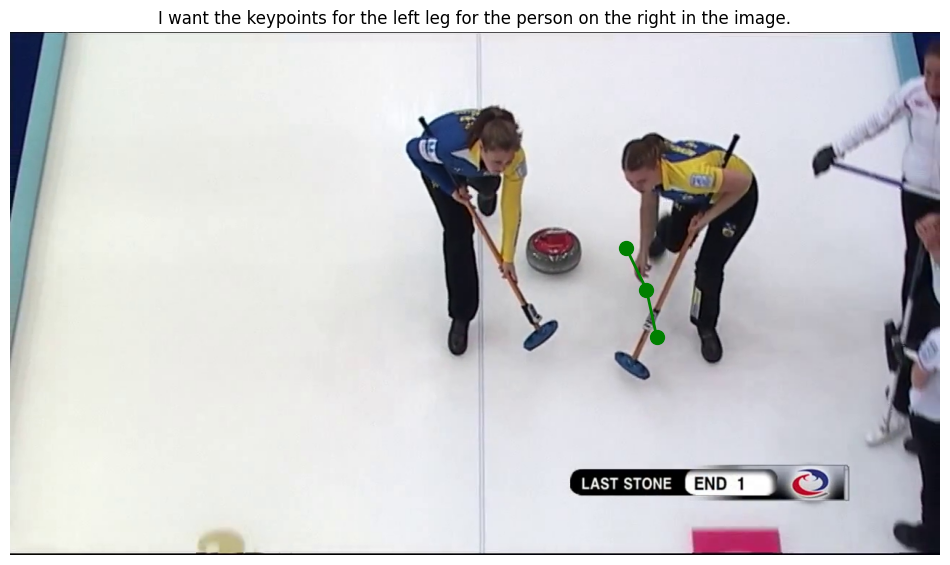

In [21]:
# 使用範例
visualizer = PoseVisualizer()

# 測試第一個範例
example = sft_dataset[1]
image = example['messages'][1]['content'][0]['image']
question = example['messages'][1]['content'][1]['text']
points = description
visualizer.visualize_pose(image, question, points)

# Utils

## PoseViualizer

In [13]:
import re
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw

class PoseVisualizer:
    def __init__(self):
        self.colors = {
            'left_arm': 'red',
            'right_arm': 'blue',
            'left_leg': 'green',
            'right_leg': 'purple'
        }

    def parse_points(self, points_str):
        """解析點位字串，例如：<points x1="54.1" y1="25.7" x2="54.1" y2="33.3" x3="53.8" y3="43.5" />"""
        pattern = r'x(\d+)="([\d.]+)" y\1="([\d.]+)"'
        matches = re.findall(pattern, points_str)
        points = [(float(x), float(y)) for _, x, y in matches]
        return points

    def get_color_from_question(self, question):
        """根據問題判斷要使用的顏色"""
        question = question.lower()
        if 'left arm' in question:
            return self.colors['left_arm']
        elif 'right arm' in question:
            return self.colors['right_arm']
        elif 'left leg' in question:
            return self.colors['left_leg']
        elif 'right leg' in question:
            return self.colors['right_leg']
        return 'black'  # 預設顏色

    def visualize_pose(self, image, question, points_str):
        """在圖片上繪製關鍵點和連接線"""
        # 將 PIL 圖片轉換為 numpy 陣列
        img_array = np.array(image)

        # 創建新的圖片用於繪製
        plt.figure(figsize=(12, 8))
        plt.imshow(img_array)

        # 解析點位
        points = self.parse_points(points_str)

        # 獲取顏色
        color = self.get_color_from_question(question)

        # 繪製點和線
        x_coords = [p[0]/ 100 * image.width for p in points]
        y_coords = [p[1]/ 100 * image.height for p in points]

        # 繪製點
        plt.scatter(x_coords, y_coords, c=color, s=100, marker='o')

        # 繪製連接線
        plt.plot(x_coords, y_coords, c=color, linewidth=2)

        # 添加問題文字
        plt.title(question, fontsize=12)

        plt.axis('off')

        return plt

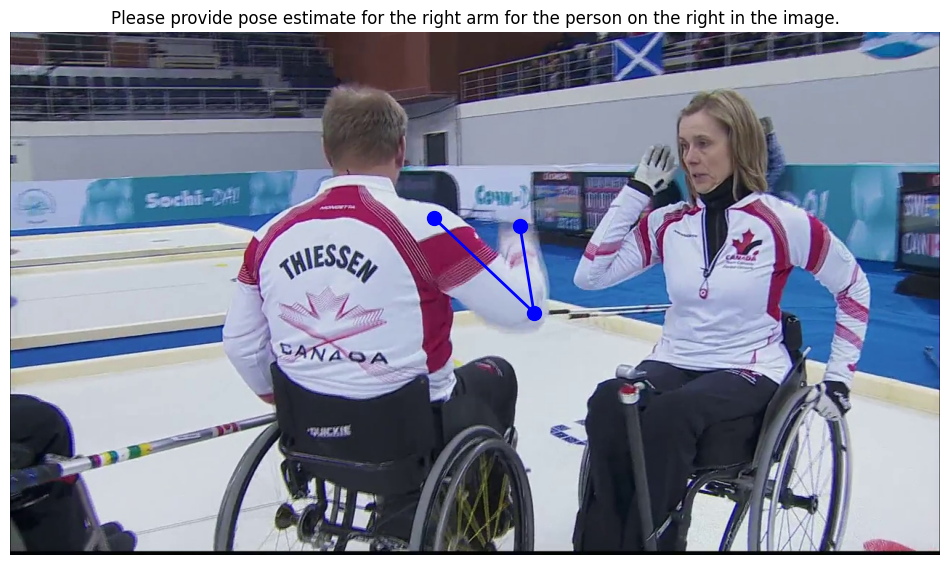

In [15]:
# 使用範例
visualizer = PoseVisualizer()

# 測試第一個範例
example = sft_dataset[3]
image = example['messages'][1]['content'][0]['image']
question = example['messages'][1]['content'][1]['text']
points = example['messages'][2]['content']

visualizer.visualize_pose(image, question, points).show()